In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import List, Tuple
import random

In [56]:
np.random.seed(3)

# Recommended reading

Bayesian parameter estimation supersedes the t-test (Kruschke):

https://www.krigolsonteaching.com/uploads/4/3/8/4/43848243/kruschke2012jepg.pdf


Blog post on bayesian inference for parameter estimation:

https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348


Doing bayesian data analysis (Kruschke) - this is a text book but it's very easy to read:

https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884/ref=sr_1_2?gclid=Cj0KCQjwtr_mBRDeARIsALfBZA5eGMYTq2sXJYqDWP7tDLtVCZyQBTF3q2i5fxBKK3yLyXk1lxZ0yWAaAtmVEALw_wcB&hvadid=177324924950&hvdev=c&hvlocphy=1018127&hvnetw=g&hvpos=1t1&hvqmt=e&hvrand=6582771769838659026&hvtargid=kwd-28002132345&hydadcr=3208_9861567&keywords=doing+bayesian+data+analysis&qid=1557190781&s=gateway&sr=8-2


Information on conjugate priors (including a table to calculate posterior distributions for conjugate priors):

https://en.wikipedia.org/wiki/Conjugate_prior


Bayes theorem:

https://en.wikipedia.org/wiki/Bayes%27_theorem

Derivation of update equations for the gaussian distribution: 

https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

# Motivation for this tutorial
## Some questions you may want to answer with data...
- Is there a difference between two groups (i.e. treatment and control)?
- Can we be sure that the difference between groups is non-zero?
- What is the magnitude of the difference and how certain are we about this magnitude?

### We need statistical methods to answer questions with data because data is noisy

### Bayesian analysis is more intuitive than traditional methods of null hypothesis testing - Kruschke

# How many people are familiar with bayesian inference?
For a quick refresher, let's take a few minutes to skim the first few paragraphs of this blog post:


https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348

# A few notes on this tutorial 
- This tutorial is not meant to supply you with everything you need to know for doing bayesian analysis (there are whole textbooks written on the topic), rather, it is meant to give you a feel for how to do it on real-ish problems, in hopes that you will read more, and maybe revisit this tutorial and try working some of your own problems.
- I feel there is a TON of information on the theory, so this tutorial focuses primarily on practical considerations that you will have to work through every time you implement any sort of bayesian analysis. 
- Don't freak out if you feel like you don't understand bayesian inference tonight (or even a few months from now). It took me many months of reading and applying it to come to an understanding myself, and I frequently need refreshers :) 
- Please feel free to stop me at any point if you have questions! 

# A few notes on Bayesian parameter estimation
- Bayesian analysis is based on Bayes theorem - but we represent models of our data using distributions rather than single values
- Bayesian parameter estimation is simply the reallocation of credibility across possible paramter values
- We realocate belief toward the parameter values that are consistent with the data, and away from parameter values are the inconsistent with the data
- We don't need p-values for bayesian inference!
- Bayesian methods can accept the null hypotheses (unlike traditional hypothesis testing methods)
- Decisions based on Bayesian analysis are better founded than traditional null hypothesis testing, whether or not the two methods agree (see the Kruschke paper mentioned above to learn more about this)
- Bayesian estimation does not require the assumption that the data are normally distributed
- The size of your data (N) and the "sharpness" of your prior impact the posterior (see page 112 - 115 in the kruschke book) 

# Some definitions:

### Bayes theorem for parameters:
P(paramter | data) = P(parameters) x P(data | parameters) / P(data)
we usually get rid of P(data) because it is just a normalizing constant to ensure our probability distribution sums to one, and it is almost always very difficult (or impossible) to calculate. If we toss out the normalizing constant P(data) bayes theorm becomes P(paramter | data) is proportional to P(parameters) x P(data | parameters) / P(data) 

You can think of it as -> Posterior is proportional to the Prior distribution (prior beliefs) x Likelihood (data) 

### Prior distribution:
P(parameters) -> expresses our previous knowledge about parameter values, without including new data (but can include previously collected data or subject matter expertise / experience) - unless you have good reason to believe otherwise, usually make the prior distribution very broad and vague so that it doesn't overwhelm the posterior

### Likelihood: 
P(data | parameters) -> Essentially, this is a model (distribution) used to represent our data

### Posterior: 
This is the result of applying bayes theorem for models - our beliefs about the parameter values after we have multiplied the prior and the likelihood

### Conjugate Distribution
A special case that arises when the posterior distribution is from the same probability distribution family as the likelihood and the prior distributions. This is helpful because when you have conjugate distributions, it is possible to analytically determine the posterior distribution. Though sometimes it is still easier to use an approximation method such as markov chain montecarlo (mcmc) to determine the posterior. 

## Example 1:
We want to estimate the *average* height of women in Boston, using the women that are in this tutorial as our sample. Select a sensible prior and likelihood, then calculate the posterior distribution. 

hint: https://www.usablestats.com/lessons/normal

In [3]:
mu_prior, sigma_prior = 65, 10 # This is our prior belief about the value of mu. 
# Usually we try to make the prior distrubution less certain (wider standard deviation) unless we are very certain
# in our prior beliefs. See page 112-115 in the Kruschke book. 

# Get the heights of everyone in the tutorial
data = [61, 70, 69, 59, 64, 57, 67]

Now we need to calculate or approximate the posterior distribution. Are our distributions conjugate? is there an equation we can use to calculate the posterior? Hint: https://en.wikipedia.org/wiki/Conjugate_prior

Is it ok to assume we know the standard deviation of the data? Sometime yes and sometimes no - when doing this in the "real world" we almost always discuss this and come to some sort of agreement depending on the situation. If at all possible we try not to make this assumption, and often use markov chain montecarlo to approximate the posterior distribution because the equations for analytically determining the posterior distribution without this assumption are *ugly*. But, for the purposes of this tutorial, this assumption will make calculating the posterior much easier (and mcmc is outside the scope for today). Since we can also look up the standard deviation of heigh for women in the US, we could use that as the standard deviation. For now we will assume that the standard deviation is known and is equal to the standard deviation of the data. But note that when you make this assumption, you can no longer calculate the posterior for standard deviation which is the other parameter of the normal distribution (unless you assume the mu is fixed). 

Note that the precision is 1 / variance - the equations are less ugly when we work with precision instead of standard deviation


Now let's make a function to calculate the posterior distribution:

In [4]:
def get_posterior(mu_prior: float, sigma_prior: float, data: List[float]) -> Tuple[float, float]:
    # In this case we will assume the variance of the data is the variance of the population
    mu_data = np.mean(data)
    precision_prior = 1 / sigma_prior ** 2 
    precision_data = 1 / np.std(data) **2
    n = len(data)
    term_1 = precision_prior * mu_prior / (n * precision_data + precision_prior)
    term_2 = precision_data * mu_data *  n / (n * precision_data + precision_prior)
    mu_posterior = term_1 + term_2
    precision_posterior = precision_prior + n * precision_data
    var_posterior = 1 / precision_posterior
    return mu_posterior, np.sqrt(var_posterior)

In [5]:
mu_posterior, sigma_posterior = get_posterior(sigma_prior=sigma_prior, mu_prior=mu_prior, data=data)
print(f"mu posterior = {mu_posterior:.2f}, sigma posterior: {sigma_posterior:.2f}")

mu posterior = 63.89, sigma posterior: 1.74


An important point that is easy to forget: the standard deviation we calculated above (sigma posterior) quantifies our uncertainty about the parameter (mu - mean height of women in boston) for which we just calculated the posterior distribution. This is *not* an estimate of the standard deviation of heights for women in boston.

If the standard deviation of the posterior is small, it means we are quite certain that our mean is near the mu_posterior value. Conversely, if the standard deviation is large, it means that we are uncertain about the value of the mean. Also notice that as N increases, it overwhelms the prior distribution.


## Example 2
 Now imagine that you are working with a chemist to determine the potency, measured in micromolar (uM), of two compounds A and B in an assay, and then determine which compound is more potent. Potency in this assay can range from < 1000 (highly potent) to > 1000 uM (not potent) - as an aside, potency usually can't be < 0, but to keep this example simple, we will say that potency can be less than 0. The chemist has measured the potency of compound A once and compound B once, which you would like to use to estimate the mean potency of each compound. You also have replicate measurements from a few standard compounds for which the true potency is known. You can use these replicates to estimate the assay variability (i.e the standard deviation of your data).

First, let's plot all of the data we have for compounds in this assay to better understand how the data are distributed.

In [57]:
all_data = np.random.normal(60, 20, 1000) # Make some example data

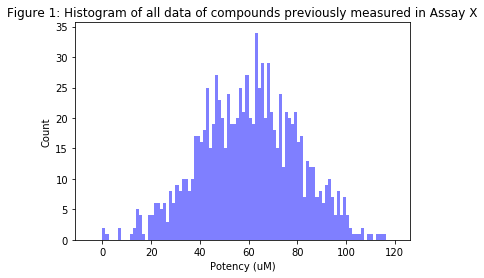

In [58]:
num_bins = 100
n, bins, patches = plt.hist(all_data, num_bins, facecolor='blue', alpha=0.5, range=[-5, 120])
plt.title('Figure 1: Histogram of all data of compounds previously measured in Assay X')
plt.xlabel('Potency (uM)')
plt.ylabel('Count')
plt.show()

Though potency can be between between < -1000 and > 1000 uM, the vast majority of compounds tested in the assay are between 0 and 120 uM (see Figure 1).  Further more, it looks like the data are normally distributed... This makes our life a lot easier. 

Here are the data for the replicates of the standard compounds in your assay: 

In [59]:
# Data for compounds x, y, z
# Hint: random noise in data is typically normally distributed, even if your data is not normally distributed - we will assume that is the case here
cmpd_x_measurements = np.random.normal(20, 2.5, 100)  # Making some example data - known potency is 20 uM for this compound
cmpd_y_measurements = np.random.normal(32, 2, 100)  # More example data - known potency is 32 uM for this compound
cmpd_z_measurements = np.random.normal(10, 1.8, 100)  # More example data - known potency is 10 uM for this compound

Now let's try to quantify the noisiness of the assay. We will do this by calculating the standard deviation of replicates for the standard, compounds X, Y, Z, for which we have 100 measurements each. Remember, it is much easier to calculate the posterior of a normal distribution if the standard deviation of the data is known. That's what we are doing here. Note that in the real world we *probably* wouldn't make this assumption.

In [60]:
cmpd_x_std, cmpd_y_std, cmpd_z_std = np.std(cmpd_x_measurements), np.std(cmpd_y_measurements), np.std(cmpd_z_measurements)

In [61]:
assay_noise_std = np.mean([cmpd_x_std, cmpd_y_std, cmpd_z_std])

In [62]:
print(f"Our assay noise standard deviation is {assay_noise_std:.2f} uM")

Our assay noise standard deviation is 2.20 uM


This means that for the same compound measured in our assay, we expect the standard deviation of the data to be ~ 2 uM.

Now we will assume that this is the fixed standard deviation of the data and we can use this "known" standard deviation to estimate the potency of each compound based on the measurements we have collected.

In [63]:
actual_a_potency, actual_b_potency = 9, 12.5 # These values are unknown to us in real life, and this is what we are trying to estimate

In [64]:
# These are the measurements that the chemist has taken of our compounds in the assay
cmpd_a_data = np.random.normal(actual_a_potency, assay_noise_std, 1)
cmpd_b_data = np.random.normal(actual_b_potency, assay_noise_std, 1)

Now we need to develop a reasonable posterior for the data... 

mu prior represents the mean of credible parameter values for the parameter that we are trying to estimate, while sigma quantifies our uncertainty (or expected variation in parameter values. These are our beliefs BEFORE we have seen the data for the compounds for which we are trying to estimate their potency.

In [65]:
mu_prior, sigma_prior = 60, 100

What we use for a prior is totally up to our discretion. This prior is based on the data plotted in Figure 1, but I have loosened the standard deviation to give our model more flexibility. 

Now lets plot our prior distribution to see if it seems reasonable

In [66]:
prior_dist = np.random.normal(mu_prior, sigma_prior, 10000)

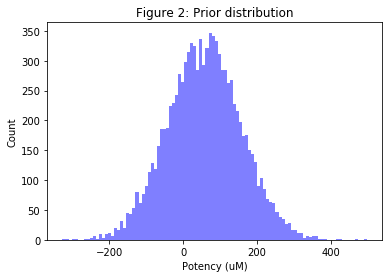

In [67]:
num_bins = 100
n, bins, patches = plt.hist(prior_dist, num_bins, facecolor='blue', alpha=0.5)
plt.title('Figure 2: Prior distribution')
plt.xlabel('Potency (uM)')
plt.ylabel('Count')
plt.show()

So we are saying that (in lieu of any other information) we believe credible values of actual potency measured in this assay are between -300 and 400 uM. This doesn't mean that there can't be any compounds outside of this range, it just means that we would need a lot of data to convince us. Now that we have our prior and our data (likelihood) let's calculate the posterior distribution:

In [68]:
def get_posterior_known_var(mu_prior: float, sigma_prior: float, data: List[float], data_sigma: float) -> Tuple[float, float]:
    # Now we will use the variance we previously calculated 
    mu_data = np.mean(data)
    precision_prior = 1 / sigma_prior ** 2 
    precision_data = 1 / data_sigma **2
    n = len(data)
    term_1 = precision_prior * mu_prior / (n * precision_data + precision_prior)
    term_2 = precision_data * mu_data *  n / (n * precision_data + precision_prior)
    mu_posterior = term_1 + term_2
    precision_posterior = precision_prior + n * precision_data
    var_posterior = 1 / precision_posterior
    return mu_posterior, np.sqrt(var_posterior)

In [69]:
mu_a, sigma_a = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=cmpd_a_data, data_sigma=assay_noise_std)
mu_b, sigma_b = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=cmpd_b_data, data_sigma=assay_noise_std)
print(f"mean of the posterior for compound a = {mu_a:.2f} with an uncertainty of = {sigma_a:.2f}")
print(f"mean of the posterior for compound b = {mu_b:.2f} with an uncertainty of = {sigma_b:.2f}")

mean of the posterior for compound a = 9.60 with an uncertainty of = 2.20
mean of the posterior for compound b = 13.92 with an uncertainty of = 2.20


Let's plot these and take a look...

In [70]:
posterior_dist_a = np.random.normal(mu_a, sigma_a, 10000)
posterior_dist_b = np.random.normal(mu_b, sigma_b, 10000)

In [71]:
x_range = [0, 25]

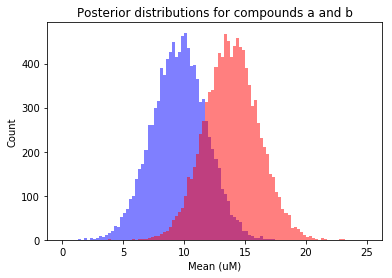

In [72]:
num_bins = 100
plt.hist(posterior_dist_a, num_bins, facecolor='blue', alpha=0.5, label="cmpd_a", range=x_range)
plt.hist(posterior_dist_b, num_bins, facecolor='red', alpha=0.5, label="cmpd_b", range=x_range)
plt.title('Posterior distributions for compounds a and b')
plt.xlabel('Mean (uM)')
plt.ylabel('Count')
plt.show()

Since we only have one data point for each compound, the ranges are quite wide.

Is compound a more potent than compound b? Let's start creating the distribution of means for each compound:

In [73]:
diff = posterior_dist_a - posterior_dist_b
frac_a_less_than_b = sum(diff < 0) / len(diff)
frac_overlapping = 1 - frac_a_less_than_b
print(f"Fraction of mass overlapping = {frac_overlapping*100:.2f}%")

Fraction of mass overlapping = 8.32%


Usually we say if < 5% the mass of the distributions is overlapping, we can be confident (statistically speaking) that the difference between a and b is non-zero (i.e. a is more potent than b). Note: you don't have to use 95% / 5% cutoff, this is up to your discretion, but 95% is commonly used to determine statistical significance). 

Now let's see what happens if we add some more data...

In [74]:
cmpd_a_data = np.random.normal(actual_a_potency, assay_noise_std, 10)
cmpd_b_data = np.random.normal(actual_b_potency, assay_noise_std, 5)

In [75]:
mu_a, sigma_a = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=cmpd_a_data, data_sigma=assay_noise_std)
mu_b, sigma_b = get_posterior_known_var(mu_prior=mu_prior, sigma_prior=sigma_prior, data=cmpd_b_data, data_sigma=assay_noise_std)
print(f"mean of the posterior for compound a = {mu_a:.2f} with an uncertainty of = {sigma_a:.2f}")
print(f"mean of the posterior for compound b = {mu_b:.2f} with an uncertainty of = {sigma_b:.2f}")

mean of the posterior for compound a = 10.19 with an uncertainty of = 0.70
mean of the posterior for compound b = 12.57 with an uncertainty of = 0.99


Notice that the posterior standard deviation has gotten much smaller indicating that we are more confident in the true value of the mean. Likewise, the mean has gotten much closer to the true value that we are trying to estimate.

Let's plot our potency estimates for the two compounds, and compare their distributions

In [76]:
posterior_dist_a = np.random.normal(mu_a, sigma_a, 10000)
posterior_dist_b = np.random.normal(mu_b, sigma_b, 10000)

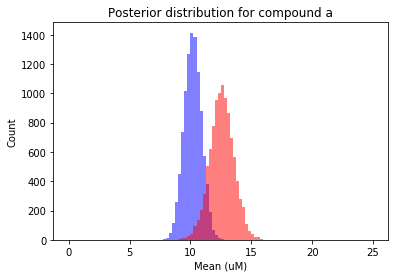

In [77]:
num_bins = 100
plt.hist(posterior_dist_a, num_bins, facecolor='blue', alpha=0.5, range=x_range)
plt.hist(posterior_dist_b, num_bins, facecolor='red', alpha=0.5, range=x_range)
plt.title('Posterior distribution for compound a')
plt.xlabel('Mean (uM)')
plt.ylabel('Count')
plt.show()

In [78]:
posterior_dist_a = np.random.normal(mu_a, sigma_a, 10000)
posterior_dist_b = np.random.normal(mu_b, sigma_b, 10000)

In [79]:
diff = posterior_dist_a - posterior_dist_b
frac_a_less_than_b = sum(diff < 0) / len(diff)
frac_overlapping = 1 - frac_a_less_than_b
print(f"Percent of mass overlapping = {frac_overlapping*100:.2f}%")

Percent of mass overlapping = 2.55%


Now we can say that the difference between a and b is non-zero or, compound a is more potent than compound b. 